<a href='https://github.com/muddie9/rockphysics_MAK'>
    <img src= 'https://user-images.githubusercontent.com/50207393/57354680-68ca3600-716c-11e9-8bf3-3054c7eec0ab.png' ,width=200,height= 200 ></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import lasio as la
import seaborn as sns
import bruges as br
import mlo_module as mlo

%matplotlib inline

# Define a default font for the figures
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 12

# Extract well log data

In [2]:
path_las ='//geus_unix_2/datafs1/Valdemar_sprint_well_data_Mads_L/DATA/'
#jude_well = lasio.read(path_las + 'Jude-1-DSN_2PETREL.las')
#jude_well = jude_well.to_csv('Jude-1-DSN_2PETREL.csv')
#jude = pd.read_csv('//geus_unix_2/datafs1/Valdemar_sprint_well_data_Mads_L/MLO documents/pythoncode_local/Jude-1-DSN_2PETREL.csv')
jude = pd.read_csv('Jude-1-DSN_2PETREL.csv')
jude = jude.fillna(0)
info_units = jude[:1]
jude = jude.drop([0]) #Getting rid of first row with units as strings
jude= jude.astype(float) #replace strings with floats 



jude.rename(columns = {"DEPT": "DEPTH", "DTC":"DT","DTS":"DTDS","DENS":"ZDEN","VSH":"VSHALE","PHIT":"PHIE"}, inplace = True) 
jude = jude.replace(np.inf, 0)

jude.DEPTH = jude.DEPTH *.3048
jude.DT = jude.DT **-1 *10**6 *.3048
jude.DTDS = jude.DTDS **-1 *10**6 *.3048
jude.ZDEN = jude.ZDEN
jude.loc[:, 'fm'] = 0 #formation index

# Renaming indices, and removing 'inf's:

#jude.rename(columns = {"DEPTH": "depth", "DT":"vp","DTDS":"vs","ZDEN":"rho"}, inplace = True) 
jude = jude.replace(np.inf, 0)

# Smoothing and despiking the logs

In [3]:

window = 13 # the length of filter is 13 samples or ~ 2 metres

# Smooth density
rho_sm = np.median(mlo.rolling_window(jude['ZDEN'],window), -1) # Smooths the logs using a median filter
jude['rho_sm'] = np.pad(rho_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Smooth P-sonic
dt_sm = np.median(mlo.rolling_window(jude['DT'],window), -1) # Smooths the logs using a median filter
jude['vp_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Smoothh S-sonic
dts_sm = np.median(mlo.rolling_window(jude['DTDS'],window), -1) # Smooths the logs using a median filter
jude['vs_sm'] = np.pad(dts_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Despike 
jude['RHOZ_edt'] = mlo.despike(jude['ZDEN'],jude['rho_sm'],max_clip=100) 
jude['DT_edt'] = mlo.despike(jude['DT'],jude['vp_sm'],max_clip=5) 
jude['DTS_edt'] = mlo.despike(jude['DTDS'],jude['vs_sm'],max_clip=5)

Y:\Valdemar_sprint_well_data_Mads_L\MLO documents\pythoncode_local\mlo_module.py:736: FutureWarning: Series.strides is deprecated and will be removed in a future version
  strides = a.strides + (a.strides[-1],)


# Define facies

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(index

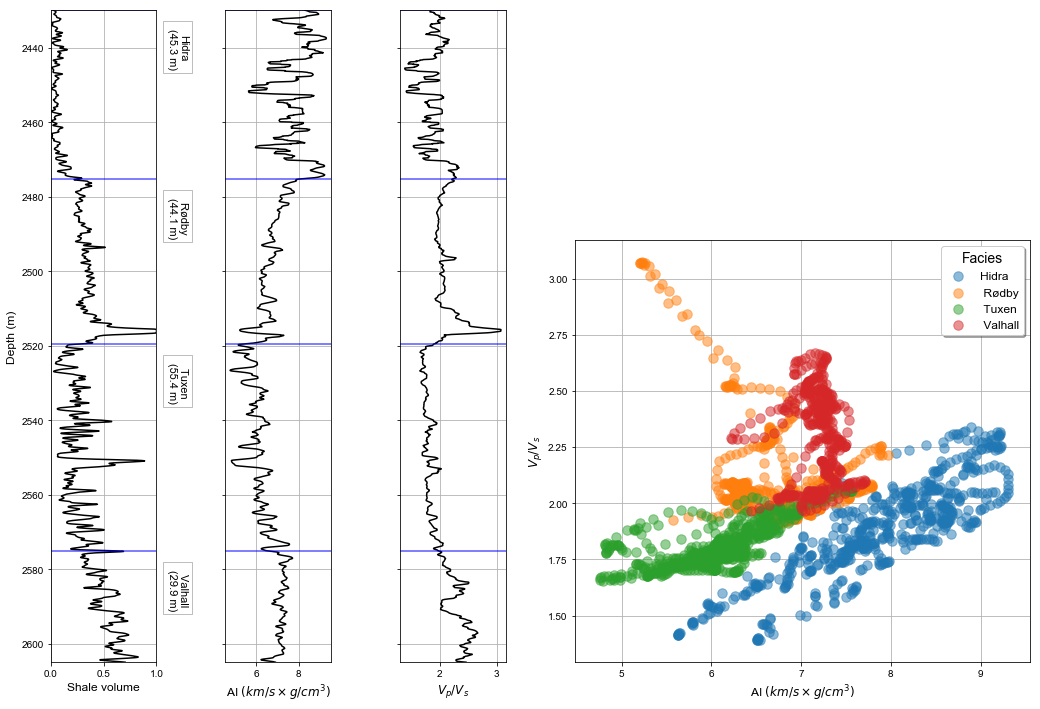

In [14]:
# Get well tops for plot annotation

#tops = pd.read_excel('Loeve_Tops.xlsx')
#tops.drop([0],inplace=True)
    
# Define elastic logs
jude['Vp'] = jude['DT_edt']
jude['Vs'] = jude['DTS_edt']
jude['AI'] = jude['Vp']/1000 * jude['RHOZ_edt']
jude['PS'] = jude['Vp'] / jude['Vs']


fm_tops = pd.read_csv(path_las+'fm_tops_JUDE.txt',header=None)

top_hidra = fm_tops[0][0]*.3048
top_rødby =  fm_tops[0][1]*.3048
top_tuxen =  fm_tops[0][2]*.3048
top_valhall = fm_tops[0][3]*.3048
top_bcu = fm_tops[0][4]*.3048


intf = [top_hidra, top_rødby, top_tuxen, top_valhall, top_bcu]
Fstr = 'Hidra, Rødby, Tuxen, Valhall'
Fstr = Fstr.split(',')


# Crop reservoir interval
resSec = jude[(jude['DEPTH'] >= float(top_hidra)) & (jude['DEPTH'] < float(top_valhall)+30)]

# Subdivide reservoir into ("0") Upper shale zone 1, ("1") Upper shale zone 2, ("2") clean reservoir zone, and ("3") shaly reservoir zone
resSec['F'] = np.zeros(len(resSec))
resSec['F_label'] = ["" for x in range(len(resSec))]

#resSec['F'].loc[(resSec['DEPTH'] < intf[0])] = 0
resSec['F'].loc[(resSec['DEPTH'] > intf[0]) & (resSec['DEPTH'] <= intf[1])] = 0
resSec['F'].loc[(resSec['DEPTH'] >= intf[0]) & (resSec['DEPTH'] <= intf[1])] = 1
resSec['F'].loc[(resSec['DEPTH'] >= intf[1]) & (resSec['DEPTH'] <= intf[2])] = 2
resSec['F'].loc[(resSec['DEPTH'] >= intf[2]) & (resSec['DEPTH'] <= intf[3])] = 3
resSec['F'].loc[(resSec['DEPTH'] >= intf[3]) & (resSec['DEPTH'] <= intf[4])] = 4

resSec['F_label'].loc[(resSec['DEPTH'] <= intf[0])] = Fstr[0]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[0]) & (resSec['DEPTH'] <= intf[1])] = Fstr[0]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[1]) & (resSec['DEPTH'] <= intf[2])] = Fstr[1]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[2]) & (resSec['DEPTH'] <= intf[3])] = Fstr[2]
resSec['F_label'].loc[(resSec['DEPTH'] >= intf[3]) & (resSec['DEPTH'] <= intf[4])] = Fstr[3]
#resSec['F_label'].loc[(resSec['DEPTH'] > intf[3])] = Fstr[3]
#resSec['F_label'].loc[(resSec['DEPTH'] >= intf[3]) & (resSec['DEPTH'] <= intf[4])] = Fstr[3]

dz = []
for m in range(1,len(Fstr)+1):
#    print(m)
    dz.append(resSec[resSec['F']==m]['DEPTH'].diff().sum())

fig = plt.figure(figsize=(16,12))

gs1 = gridspec.GridSpec(nrows=3, ncols=6, left = 0.05, wspace=0.65)
ax1 = fig.add_subplot(gs1[:, 0])
ax2 = fig.add_subplot(gs1[:, 1])
ax3 = fig.add_subplot(gs1[:, 2])
ax4 = fig.add_subplot(gs1[1:3, 3:6])

# Shale volume
ax1.plot(resSec['VSHALE'],resSec['DEPTH'],'k-')
ax1.axis('tight')
ax1.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax1.invert_yaxis()
ax1.set_xlim(0,1)
ax1.set_xlabel('Shale volume', fontsize = 12)
ax1.set_ylabel('Depth (m)', fontsize = 12)
ax1.grid()

# AI
ax2.plot(resSec['AI'],resSec['DEPTH'],'k-')
ax2.axis('tight')
ax2.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax2.invert_yaxis()
ax2.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax2.set_yticklabels('')
ax2.grid()

# Vp/Vs
ax3.plot(resSec['PS'],resSec['DEPTH'],'k-')
ax3.axis('tight')
ax3.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax3.invert_yaxis()
ax3.set_xlabel(r'$V_p/V_s$', fontsize = 12)
ax3.set_yticklabels('')
ax3.grid()

for n in range(0,len(intf)):
    ax1.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)    
    ax2.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    ax3.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    
for i in range(len(Fstr)):
    #print(i)
    ax1.text(x = ax1.set_xlim()[1]+0.2, y =intf[i]+10, s = Fstr[i]+'\n ({0} m)'.format(str(round(dz[i],1))),
            fontsize = '11',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
            weight = 'light',
            rotation=-90)

# AI vs Vp/Vs

groups = resSec['F_label'].unique()

for i in range(len(groups)):
    x, y = (resSec[resSec['F_label']==groups[i]]['AI'],resSec[resSec['F_label']==groups[i]]['PS'])
    if (groups[i]=='Lower Ørslev'):
        ax4.plot(resSec[resSec['F_label']==groups[i]]['AI'],
                 resSec[resSec['F_label']==groups[i]]['PS'],'kx',lw=2,label=groups[i])
    else:
        ax4.scatter(x, y, alpha=0.5, s=90, label=groups[i])


ax4.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
ax4.set_ylabel(r'$V_p/V_s$', fontsize = 12)
#ax4.set_xlim(6,17)
ax4.grid()
ax4.set_axisbelow(True)
lg = plt.legend(loc=1,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('x-plot.png',dpi=400)
plt.show()

# Blocky model input

In [15]:
###########################################################
#       DEFINE MODELING PARAMETERS HERE

#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]

vp_mod = resSec.groupby('F').mean()['Vp'].values  # P-wave velocity (m/s)

vs_mod = resSec.groupby('F').mean()['Vs'].values   # S-wave velocity (m/s)

rho_mod = resSec.groupby('F').mean()['RHOZ_edt'].values   # Density

lit_mod = resSec.groupby('F').mean()['VSHALE'].values   # Shale

phi_mod = resSec.groupby('F').mean()['PHIE'].values   # Density




thickness = np.round(dz,1)[1:-1] # vertical thickness of layer 2 in metres

#   Angle range for incident rays
theta1_min = 0.0    # best to leave this set to zero
theta1_max = 40.0
theta1_step= 1.0


#   Wavelet Parameters
wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 35.0  # Ricker wavelet central frequency
f1 = 3.0          # Bandpass wavelet low truncation frequency
f2 = 8.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency


#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality


#   Plotting Display Parameters
min_plot_time = 0.02
max_plot_time = 0.25
excursion = 2

# Computations

In [6]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nangles = int( (theta1_max-theta1_min)/theta1_step + 1)


#   Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = mlo.ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = mlo.wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

#   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

#   Calculate reflectivities from model parameters
rc_zoep_pp = []
theta1 = []
for i in range(0, nangles):
    theta1_buf = i*theta1_step + theta1_min
    rc_buf1 = mlo.rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
    rc_buf2 = mlo.rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)
    rc_buf3 = mlo.rc_zoep(vp_mod[2], vs_mod[2], rho_mod[2], vp_mod[3], vs_mod[3], rho_mod[3], theta1_buf)
    #rc_buf4 = rc_zoep(vp_mod[3], vs_mod[3], rho_mod[3], vp_mod[4], vs_mod[4], rho_mod[4], theta1_buf)
    #rc_buf5 = rc_zoep(vp_mod[4], vs_mod[4], rho_mod[4], vp_mod[5], vs_mod[5], rho_mod[5], theta1_buf)
    
    theta1.append(theta1_buf)
    rc_zoep_pp.append([rc_buf1[0,0], rc_buf2[0,0], rc_buf3[0,0]])


#   Define time sample vector for output model & traces
nsamp = int((tmax-tmin)/dt) + 1
t = []
for i in range(0,nsamp):
    t.append(i*dt)


syn_zoep_pp = []
lyr_times = []
#print("\n\nStarting synthetic calcuations...\n")
for angle in range(0, nangles):
    
    dz_app = thickness
    
    #   To calculate apparent thickness of layer 2 based on incidence angle
    #   uncomment the following three rows (e.g. ray-synthetics)
    #p = ray_param(vp_mod[0], angle)
    #angle2 = math.degrees(math.asin(p*vp_mod[1]))
    #dz_app = thickness/math.cos(math.radians(angle2))
    
    #   Calculate interface depths
    z_int = [200, 0, 0]
    for i in range(1,nint):
        z_int[i] = z_int[i-1]+dz_app[i-1]
    
    #   Calculate interface times
    t_int = mlo.calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    rc = mlo.digitize_model(rc_zoep_pp[angle], t_int, t)

    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    #syn_buf = list(syn_buf)
    syn_zoep_pp.append(syn_buf)
    print("Calculated angle %i" % (angle))


#    Convert data arrays from lists/tuples to numpy arrays    
syn_zoep_pp = np.array(syn_zoep_pp)
rc_zoep_pp = np.array(rc_zoep_pp)
t = np.array(t)


#   Calculate array indicies corresponding to top/base interfaces
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')
lyr1_indx = list(lyr_indx[:,0])
lyr2_indx = list(lyr_indx[:,1])
lyr3_indx = list(lyr_indx[:,2])
#lyr4_indx = list(lyr_indx[:,3])
#lyr5_indx = list(lyr_indx[:,4])

#   Copy convolved top/base reflectivity values to Lists for easier plotting
[ntrc, nsamp] = syn_zoep_pp.shape
line1 = []
line2 = []
line3 = []
#line4 = []
#line5 = []
for i in range(0, ntrc):
    line1.append(syn_zoep_pp[i,lyr1_indx[i]])
    line2.append(syn_zoep_pp[i,lyr2_indx[i]])
    line3.append(syn_zoep_pp[i,lyr3_indx[i]])
#    line4.append(syn_zoep_pp[i,lyr4_indx[i]])
#    line5.append(syn_zoep_pp[i,lyr5_indx[i]])

#   AVO inversion for NI and GRAD from analytic and convolved reflectivity
#   values and print the results to the command line.  Linear least squares
#   method is used for estimating NI and GRAD coefficients.
Yzoep = np.array(rc_zoep_pp[:,0])
Yzoep = Yzoep.reshape((ntrc, 1))

Yconv = np.array(line1)
Yconv = Yconv.reshape((ntrc, 1))

ones = np.ones(ntrc)
ones = ones.reshape((ntrc,1))

sintheta2 = np.sin(np.radians(np.arange(0, ntrc)))**2
sintheta2 = sintheta2.reshape((ntrc, 1))

X = np.hstack((ones, sintheta2))

#   ... matrix solution of normal equations
Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

#print('\n\n')
#print( '  Method       NI         GRAD')
#print( '---------------------------------')
#print( ' Zoeppritz%11.5f%12.5f' % (Azoep[0], Azoep[1]))
#print( ' Convolved%10.5f%12.5f' % (Aconv[0], Aconv[1]))


    
#   Create a "digital" time domain version of the input property model for 
#   easy plotting and comparison with the time synthetic traces
vp_dig = np.zeros(t.shape)
vs_dig = np.zeros(t.shape)
rho_dig = np.zeros(t.shape)
lit_dig = np.zeros(t.shape)
phi_dig = np.zeros(t.shape)

vp_dig[0:lyr1_indx[0]] = vp_mod[0]
vp_dig[(lyr1_indx[0]):lyr2_indx[0]] = vp_mod[1]
vp_dig[(lyr2_indx[0]):lyr3_indx[0]] = vp_mod[2]
vp_dig[(lyr3_indx[0]):] = vp_mod[3]
#vp_dig[(lyr3_indx[0]):lyr4_indx[0]] = vp_mod[3]
#vp_dig[(lyr4_indx[0]):lyr5_indx[0]] = vp_mod[4]
#vp_dig[(lyr5_indx[0]):] = vp_mod[5]

vs_dig[0:lyr1_indx[0]] = vs_mod[0]
vs_dig[(lyr1_indx[0]):lyr2_indx[0]] = vs_mod[1]
vs_dig[(lyr2_indx[0]):lyr3_indx[0]] = vs_mod[2]
vs_dig[(lyr3_indx[0]):] = vs_mod[3]
#vs_dig[(lyr3_indx[0]):lyr4_indx[0]] = vs_mod[3]
#vs_dig[(lyr4_indx[0]):lyr5_indx[0]] = vs_mod[4]
#vs_dig[(lyr5_indx[0]):] = vs_mod[5]

rho_dig[0:lyr1_indx[0]] = rho_mod[0]
rho_dig[(lyr1_indx[0]):lyr2_indx[0]] = rho_mod[1]
rho_dig[(lyr2_indx[0]):lyr3_indx[0]] = rho_mod[2]
rho_dig[(lyr3_indx[0]):] = rho_mod[3]

#rho_dig[(lyr3_indx[0]):lyr4_indx[0]] = rho_mod[3]
#rho_dig[(lyr4_indx[0]):lyr5_indx[0]] = rho_mod[4]
#rho_dig[(lyr5_indx[0]):] = rho_mod[5]

lit_dig[0:lyr1_indx[0]] = lit_mod[0]
lit_dig[(lyr1_indx[0]):lyr2_indx[0]] = lit_mod[1]
lit_dig[(lyr2_indx[0]):lyr3_indx[0]] = lit_mod[2]
lit_dig[(lyr3_indx[0]):] = lit_mod[3]

#lit_dig[(lyr3_indx[0]):lyr4_indx[0]] = lit_mod[3]
#lit_dig[(lyr4_indx[0]):lyr5_indx[0]] = lit_mod[4]
#lit_dig[(lyr5_indx[0]):] = lit_mod[5]

phi_dig[0:lyr1_indx[0]] = phi_mod[0]
phi_dig[(lyr1_indx[0]):lyr2_indx[0]] = phi_mod[1]
phi_dig[(lyr2_indx[0]):lyr3_indx[0]] = phi_mod[2]
phi_dig[(lyr3_indx[0]):] = phi_mod[3]

#phi_dig[(lyr3_indx[0]):lyr4_indx[0]] = phi_mod[3]
#phi_dig[(lyr4_indx[0]):lyr5_indx[0]] = phi_mod[4]
#phi_dig[(lyr5_indx[0]):] = phi_mod[5]


Calculated angle 0
Calculated angle 1
Calculated angle 2
Calculated angle 3
Calculated angle 4
Calculated angle 5
Calculated angle 6
Calculated angle 7
Calculated angle 8
Calculated angle 9
Calculated angle 10
Calculated angle 11
Calculated angle 12
Calculated angle 13
Calculated angle 14
Calculated angle 15
Calculated angle 16
Calculated angle 17
Calculated angle 18
Calculated angle 19
Calculated angle 20
Calculated angle 21
Calculated angle 22
Calculated angle 23
Calculated angle 24
Calculated angle 25
Calculated angle 26
Calculated angle 27
Calculated angle 28
Calculated angle 29
Calculated angle 30
Calculated angle 31
Calculated angle 32
Calculated angle 33
Calculated angle 34
Calculated angle 35
Calculated angle 36
Calculated angle 37
Calculated angle 38
Calculated angle 39
Calculated angle 40


# Plotting

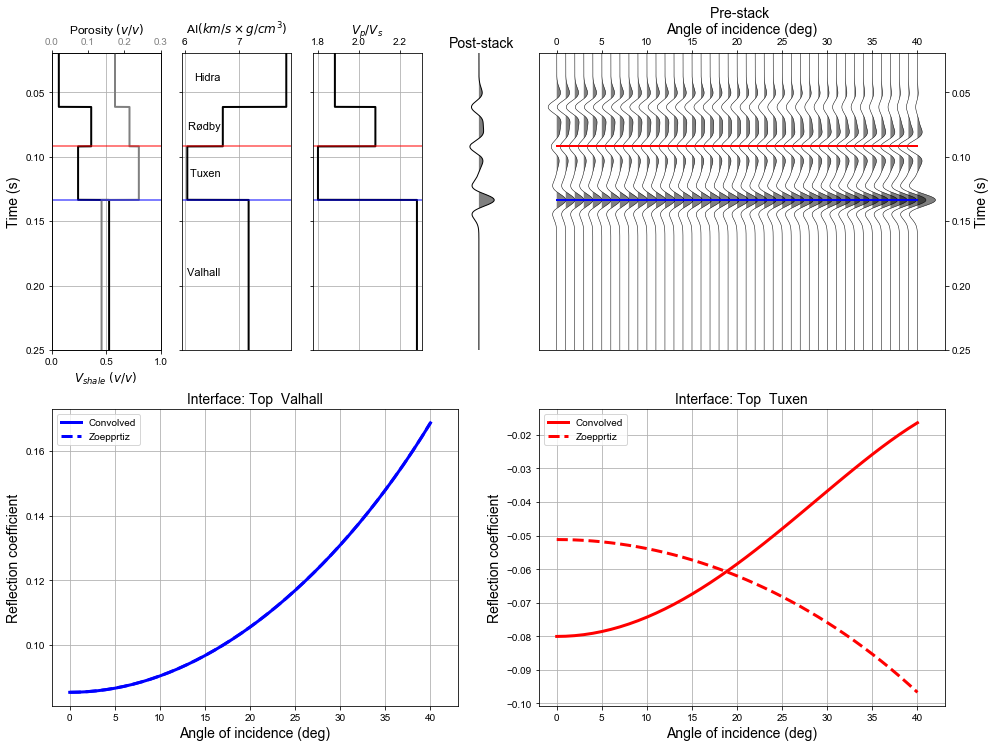

In [7]:
#############################################
#
#       PLOTTING HAPPENS BELOW HERE
#
#   Create the plot figure
fig = plt.figure(figsize=(16, 12))
fig.set_facecolor('white')


#   Plot log curves in two-way time
ax0a = fig.add_subplot(2,7,1)
l_lit_dig, = ax0a.plot(lit_dig, t, 'k', lw=2)
ax0a.set_ylim((min_plot_time,max_plot_time))
ax0a.set_xlim(0, 1.0)
ax0a.invert_yaxis()
ax0a.set_ylabel('Time (s)', fontsize = 14)
ax0a.xaxis.tick_bottom()
ax0a.xaxis.set_label_position('bottom')
ax0a.set_xlabel(r'$V_{shale} \ (v/v)$', fontsize = 12)
ax0a.grid()

cl = 'grey'
ax0a2 = ax0a.twiny()  # instantiate a second axes that shares the same y-axis
l_phi_dig = ax0a2.plot(phi_dig, t, color=cl,lw=2)
ax0a2.tick_params(axis='x', labelcolor=cl)
ax0a2.set_xlabel('Porosity ' + r'$(v/v)$', fontsize = 12)
ax0a2.set_xlim(0,0.3)
ax0a2.axhline(lyr_times[0,2], color='blue', lw=2, alpha=0.5)
ax0a2.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)

ax0b = fig.add_subplot(272)
l_ai_dig, = ax0b.plot((vp_dig/1000)*(rho_dig), t, 'k', lw=2)
ax0b.set_ylim((min_plot_time,max_plot_time))
ax0b.invert_yaxis()
ax0b.xaxis.tick_top()
ax0b.xaxis.set_label_position('top')
ax0b.set_xlabel('AI' + r'$(km/s \times g/cm^3)$', fontsize = 12)
ax0b.set_yticklabels('')
ax0b.axhline(lyr_times[0,2], color='blue', lw=2, alpha=0.5)
ax0b.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0b.grid()

x = 6.65

plt.text(x,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        Fstr[0],
        fontsize=11,
        horizontalalignment='right')
plt.text(x,
        lyr_times[0,1] + (lyr_times[0,0] - lyr_times[0,1])/2. + 0.002,
        Fstr[1],
        fontsize=11,
        horizontalalignment='right')
plt.text(x,
        lyr_times[0,2] + (lyr_times[0,1] - lyr_times[0,2])/2. + 0.002,
        Fstr[2],
        fontsize=11,
        horizontalalignment='right')
plt.text(x,
        lyr_times[0,2] + (max_plot_time - lyr_times[0,2])/2.,
        Fstr[3],
        fontsize=11,
        horizontalalignment='right')



ax0c = fig.add_subplot(273)
l_ps_dig, = ax0c.plot(vp_dig/vs_dig, t, 'k', lw=2)
ax0c.set_ylim((min_plot_time,max_plot_time))
ax0c.invert_yaxis()
ax0c.xaxis.tick_top()
ax0c.xaxis.set_label_position('top')
ax0c.set_xlabel(r'$V_p/V_s$', fontsize = 12)
#ax0c.set_xlim([1.8,2.3])
ax0c.set_yticklabels('')
ax0c.axhline(lyr_times[0,2], color='blue', lw=2, alpha=0.5)
ax0c.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0c.grid()

# Plot post-stack trace
ax1 = fig.add_subplot(2,28,14)
pst = syn_zoep_pp.T.sum(axis=1) # Stacked trace
ax1.plot(pst,t,'k',lw=1)
ax1.fill_betweenx(t, pst, 0, pst>0, facecolor='k', linewidth=0,alpha=0.5)
#ax1.fill_betweenx(t, pst, 0, pst<0, facecolor=[0.6,0.6,1.0], linewidth=0)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.invert_yaxis()
ax1.set_axis_off()
ax1.set_title('Post-stack', fontsize=14)

# Plot pre-stack traces
ax2 = fig.add_subplot(222)
mlo.plot_vawig(ax2, syn_zoep_pp, t, excursion)
ax2.set_ylim((min_plot_time,max_plot_time))
l_int3 = ax2.plot(lyr_times[:,2], color='blue', lw=2)
l_int5 = ax2.plot(lyr_times[:,1], color='red', lw=2)
ax2.invert_yaxis()
#label_str = 'Synthetic angle gather\nLayer 2 thickness = %4.1fm' % thickness
ax2.set_xlabel('Pre-stack \nAngle of incidence (deg)', fontsize = 14)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Time (s)', fontsize = 14)

#   Plot Zoeppritz and convolved reflectivity curves    
ax3 = fig.add_subplot(2,2,3)

l_syn1, = ax3.plot(line3, color='blue', linewidth=3)
l_rc1, = ax3.plot( rc_zoep_pp[:,2], '--', color='blue', lw=3)

ax3.set_xlim((-excursion, ntrc+excursion))
ax3.grid()
ax3.set_xlabel('Angle of incidence (deg)', fontsize = 14)
ax3.set_ylabel('Reflection coefficient', fontsize = 14)
ax3.set_title('Interface: Top '+Fstr[3] , fontsize = 14)
plt.legend([l_syn1, l_rc1], ['Convolved', 'Zoepprtiz'], loc=0)

ax4 = fig.add_subplot(2,2,4)
l_syn2, = ax4.plot(line1, color='red', linewidth=3)
l_rc2, = ax4.plot(rc_zoep_pp[:,1], '--', color='red', lw=3)
ax4.set_xlim((-excursion, ntrc+excursion))
ax4.grid()
ax4.set_xlabel('Angle of incidence (deg)', fontsize = 14)
ax4.set_ylabel('Reflection coefficient', fontsize = 14)
ax4.set_title('Interface: Top ' +Fstr[2], fontsize = 14)
plt.legend([l_syn2, l_rc2], ['Convolved', 'Zoepprtiz'], loc=0)

#   Save the plot
#plt.savefig('blocky_AVO.png',dpi = 400)

#   Display the plot
plt.show()

# Rock physics modelling

## Isoframe Model

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


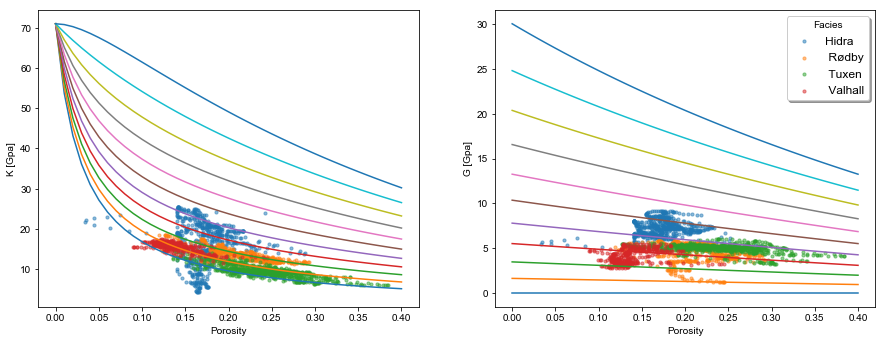

In [8]:
resSec['K'], resSec['mu'] = mlo.bulk_shear(resSec.Vp,resSec.Vs, resSec.RHOZ_edt*1000.)

mlo.IF()
fig = plt.gcf()
ax1, ax2= fig.get_axes()


for i in range(len(groups)):
    x, y = (resSec[resSec['F_label']==groups[i]]['PHIE'],resSec[resSec['F_label']==groups[i]]['K'])
    ax1.scatter(x, y, alpha=0.5, s=10, label=groups[i])
    x, y = (resSec[resSec['F_label']==groups[i]]['PHIE'],resSec[resSec['F_label']==groups[i]]['mu'])
    ax2.scatter(x, y, alpha=0.5, s=10, label=groups[i])

#ax4.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 12)
#ax4.set_ylabel(r'$V_p/V_s$', fontsize = 12)
#ax4.set_xlim(6,17)
#ax1.set_axisbelow(True)
lg = plt.legend(loc=1,title='Facies',fontsize=12,fancybox=True,shadow=True)
#plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('k_mu_jude.png',dpi=400)
#plt.show()



if strcmp(model,'patchy')
    
    MSpecs                  = struct(...
        'Name',                 'patchy', ...
        'QK',                   geqHill(71,0.9,38), ... % Mixture of calcite and quartz
        'QMu',                  geqHill(30,0.9,44), ... % Mixture of calcite and quartz
        'QRho',                 2.71, ...
        'CK',                   14, ...
        'CMu',                  5, ...
        'CRho',                 2.4, ...
        'useGassmann',          true, ...
        'PhiC',                 0.45, ...
        'PhiCCT',               0.43, ...
        'CCTscheme',            1,...
        'relaxation',           0.3,...
        'CCTVolFrac',           0.4,...
        'brieExp',              3,...
        'pressure',             35, ...
        'porePressure',         35, ...
        'temperature',          90, ...
        'salinity',             0.03,...
        'gasGravity',           0.7, ...
        'oilK',                 0.82, ...
        'oilRho',               0.8, ...
        'brineK',               2.77, ...
        'brineRho',             1, ...
        'fluid',                'oil', ...
        'fluidMixing',          'brie', ...   % patchy|homogeneous|voigt|reuss
        'solidMiding',          'hill', ...     % voigt|hill|reuss|hswl|hswu
        'sortingMixing',        'hswl',...      % voigt|hill|reuss|hswl|hswu
        'patchyMixing',         'hswl',...      % voigt|hill|reuss|hswl|hswu
        'ngrid',                false,...
        'func',                 @gmodPatchyCCT); 


# Rock Physics for Tuxen @ Jude-1X

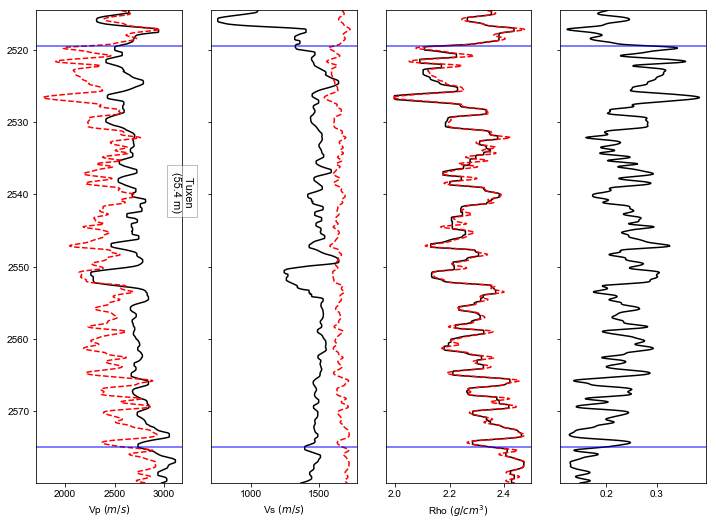

In [9]:
resSec = jude[(jude['DEPTH'] >= float(top_tuxen)-5) & (jude['DEPTH'] < float(top_valhall)+5)]

QK = mlo.hill(71,0.9,38) # Mixture of calcite and quartz
QMu = mlo.hill(30,0.9,44) # Mixture of calcite and quartz
QRho = 2.71  #quartz = 2,65

CK = 8
CMu = 3
CRho = 2.65

f_ca = 0.85
K_ca = mlo.hill(QK,f_ca,CK)
G_ca = mlo.hill(QMu,f_ca,CMu)



rho_brine = 1.
rho_oil = 0.8
    
rho_f = resSec.SWT * rho_brine + (1-resSec.SWT)*rho_oil

rho_m = resSec.VSHALE*CRho + (1-resSec.VSHALE)*QRho
Rho = resSec.PHIE * rho_f + (1-resSec.PHIE)* rho_m

#Por= np.arange(0,.41,0.01)
Por = resSec.PHIE

####################

#WT = input('wet or dry sample? 0-dry, 1-wet:\n')
WT = 1
K_w = 2.2

fig = plt.figure(figsize = (12,40))
ax1, ax2, ax3, ax4 = fig.add_subplot(441), fig.add_subplot(442), fig.add_subplot(443), fig.add_subplot(444)
ax1.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH'])), ax2.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH'])),
ax3.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH'])),ax4.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax2.set_yticklabels(''), ax3.set_yticklabels(''), ax4.set_yticklabels('')
ax1.set_xlabel(r'Vp $(m/s)$'), ax2.set_xlabel(r'Vs $(m/s)$'), ax3.set_xlabel(r'Rho $(g/{cm}^3)$')
ax1.invert_yaxis(), ax2.invert_yaxis(), ax3.invert_yaxis(), ax4.invert_yaxis();



ax1.plot(resSec.Vp, resSec.DEPTH,'k')
ax2.plot(resSec.Vs, resSec.DEPTH,'k')
ax3.plot(resSec.rho_sm,resSec.DEPTH,'k',label = 'Jude-1X')
ax3.plot(Rho, resSec.DEPTH,'r--',label = 'IF Model')
ax4.plot(resSec.PHIE,resSec.DEPTH,'k')

IF = np.arange(0,1.1,0.1)

K_out = np.zeros([IF.size,Por.size])
G_out = np.zeros([IF.size,Por.size])

#for i in range(1,IF.size,3):
#    print(i)
i = 6#i=3

f1=IF[i]*(1-Por)
f2=Por+(1-IF[i])*(1-Por)

if WT == 0:
    K_sus=K_a                                     ### for dry sample
elif WT==1:
    K_sus= ( (Por/K_w) + (((1-Por)+Por*(1-IF[i])) / K_ca) )**(-1)   ###  for wet sample

#K=K_ca+f2/((K_sus-K_ca)**(-1)+f1*(K_ca+4/3*G_ca)**(-1))
#G=G_ca+ f2/(2*f1*(K_ca+2*G_ca)/(5*G_ca*(K_ca+4/3*G_ca))-1/G_ca)

    
zeta=G_ca/6*((9*K_ca+8*G_ca)/(K_ca+2*G_ca))
K=((Por+(1-IF[i])*(1-Por))/(K_sus+4/3*G_ca)+(IF[i]*(1-Por)/(K_ca+4/3*G_ca)))**(-1)-40; ## calibrated Ida -perfect, 40 replaced as 4/3*G_ca?
G=((Por+(1-IF[i])*(1-Por))/zeta+IF[i]*(1-Por)/(G_ca+zeta))**(-1)-zeta;                 ## calibrated Ida -perfect, zeta=33.55


M=K+4/3*G
Vp=(M/Rho)**0.5 * 1000.
Vs=(G/Rho)**0.5 * 1000.

K_out[i,:]=K 
G_out[i,:]=G 

ax1.plot(Vp, resSec.DEPTH,'r--')
ax2.plot(Vs, resSec.DEPTH,'r--')

for n in range(0,len(intf)):
    ax1.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)    
    ax2.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    ax3.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)
    ax4.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.5)

i=2
ax1.text(x = ax1.set_xlim()[1]+0.2, y =intf[i]+20, s = Fstr[i]+'\n ({0} m)'.format(str(round(dz[i],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=-90);
#plt.legend()